# Person Painting

This notebook does effects based on segmentation of people in a photo (can specify which segmentation model based on a number of options.) The effects include: 1) rendering the entire image in black & white except for the people, 2) replacing the people pixels with patches sampled from similar horizontal regions in the image.

See the below examples of processed images.

In [27]:
%matplotlib inline
import torch
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 
import numpy as np
from fastai.vision import *
from torchvision.utils import save_image
from fastai import *
from pathlib import Path
from skimage.transform import rescale
from skimage.morphology import binary_erosion, binary_dilation
from skimage.draw import ellipse
from skimage.measure import label, regionprops
from PIL import Image
from matplotlib import cm
from skimage.util import img_as_float, img_as_ubyte
from skimage.color import rgb2hsv,hsv2rgb
import skimage.io
import os
import sys
import math
from scipy.ndimage import gaussian_filter
import warnings
warnings.filterwarnings("ignore")

# Need to install the following on this machine above and beyond standard anaconda install
# make sure you have xcode on a mac: xcode-select --install
# clone the code: git clone https://github.com/matterport/Mask_RCNN.git
#imgaug, tensorflow>=1.3.0, keras>=2.0.8, opencv-python
# See: 

In [2]:
# Including RCNN/Coco segmentation (as this one actually works)
ROOT_DIR = os.path.abspath("/Users/jimkleban/Documents/Coding/")
sys.path.append(ROOT_DIR)  # To find local version of the library
sys.path.append(os.path.join(ROOT_DIR, "Mask_RCNN"))
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize

# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "Mask_RCNN/samples/coco"))  # To find local version
sys.path.append(os.path.join(ROOT_DIR, "cocoapi/PythonAPI"))  # To find local version
import coco

Using TensorFlow backend.


In [3]:
# Needed for Fast.ai model inference (ugly but can't easily take out)
def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [4]:
testfile = 'mummies.jpg'

# COCO Class names
coco_class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

In [5]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Processing 1 images
image                    shape: (3381, 5072, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 5072.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


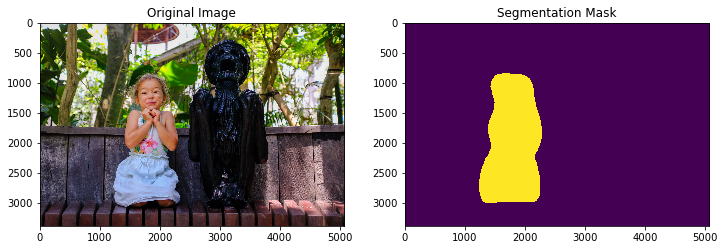

In [6]:
class Segmentor:
    def __init__(self, segmentor_type='unet_camvid_fastai'):
        self.segmentor_type = segmentor_type
        # Available segmentors: unet_camvid_fastai, TBD: maskrcnn_coco_tf
        
        # initialize here (saves time when running on multiple images)        
        if self.segmentor_type == 'unet_camvid_fastai':
            modelpath = Path('/Users/jimkleban/Documents/Coding/imageparty/models')
            self.fastai_learn = load_learner(modelpath)
            
        elif self.segmentor_type == 'maskrcnn_coco_tf':
            MODEL_DIR = os.path.join(ROOT_DIR, "logs")
            COCO_MODEL_PATH = os.path.join('', "imageparty/models/mask_rcnn_coco.h5")
            config = InferenceConfig()
            #config.display()
            self.maskrcnn_model = modellib.MaskRCNN(mode="inference", model_dir='mask_rcnn_coco.hy', config=config)
            self.maskrcnn_model.load_weights('models/mask_rcnn_coco.h5', by_name=True)
        
    def segment(self,imagepath):
        if self.segmentor_type == 'unet_camvid_fastai':
            image_to_segment = open_image(imagepath)            
            transfimg,a,b,c = self.fastai_learn.predict(image_to_segment, return_x=True)
            
            b1 = b[0]
            d = (b1==0).numpy() # CAMVID classes corresponding to child, pedestrian, etc
            e = (b1==2).numpy()
            f = (b1==7).numpy()
            g = (b1==16).numpy()
            h = np.bitwise_or(d,e)
            i = np.bitwise_or(f,h)
            mask = np.bitwise_or(g,i)
            outimg = transfimg.data.numpy()
            outimg = np.moveaxis(outimg, 0, -1)
            
        elif self.segmentor_type == 'maskrcnn_coco_tf':
            outimg = skimage.io.imread(imagepath)
            #scalefactor = 1024 / max(outimg.shape[0],outimg.shape[1])
            #outimg = rescale(outimg, scalefactor, anti_aliasing=True, multichannel=True)
            results = self.maskrcnn_model.detect([outimg], verbose=1)
            r = results[0]
            #visualize.display_instances(outimg, r['rois'], r['masks'], r['class_ids'], coco_class_names, r['scores'])
            mask = np.zeros((outimg.shape[0],outimg.shape[1]),dtype='bool')
            for n in range(0,len(r['class_ids'])):
                if r['class_ids'][n] == 1:
                    mask = np.bitwise_or(mask,r['masks'][:,:,n])
        else:
            outimg = skimage.io.imread(imagepath)
            mask = None
            
        return outimg, mask
            
    def showresults(self, baseimage, maskimage):   
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(12,12)
        ax1.set_title('Original Image')
        ax1.imshow(baseimage)
        ax2.set_title('Segmentation Mask')
        ax2.imshow(maskimage)

#segmentor = Segmentor('unet_camvid_fastai')
#testtransimg, testmask = segmentor.segment(testfile)
#segmentor.showresults(testtransimg, testmask)

segmentor = Segmentor('maskrcnn_coco_tf')
testtransimg, testmask = segmentor.segment(testfile)
segmentor.showresults(testtransimg, testmask)

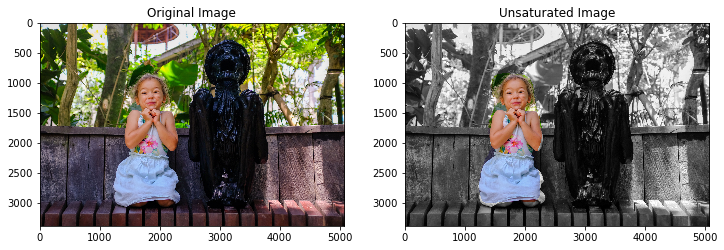

In [7]:
def unsaturate(image,mask):
    # Take input mask and desaturate everything else
    hsvimage = rgb2hsv(image)
    hsvimage[mask==0,1] = 0
    rgbimage = hsv2rgb(hsvimage)
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(12,12)
    ax1.set_title('Original Image')
    ax1.imshow(image)
    ax2.set_title('Unsaturated Image')
    ax2.imshow(rgbimage)
    return rgbimage

unsaturatedimg = unsaturate(testtransimg,testmask)

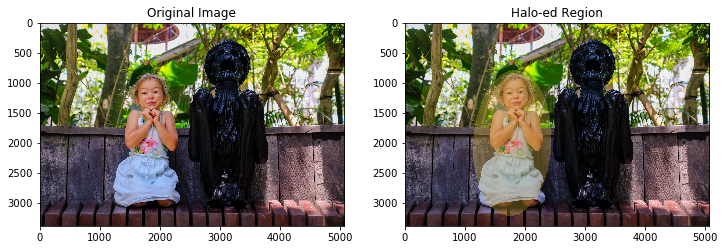

In [16]:
def addhalo(image,mask):
    alphaparam = 0.67
    outimage = np.copy(image)
    regions = regionprops(label(mask))
    for props in regions:   
        y0, x0 = props.centroid
        orientation = props.orientation
        rr, cc = ellipse(props.centroid[0], props.centroid[1], 0.5*props.major_axis_length \
                        , 0.65*props.minor_axis_length, shape = image.shape, rotation = orientation)
        outimage[rr,cc,0] = alphaparam*outimage[rr,cc,0] + (1.0 - alphaparam) * 212
        outimage[rr,cc,1] = alphaparam*outimage[rr,cc,1] + (1.0 - alphaparam) * 175
        outimage[rr,cc,2] = alphaparam*outimage[rr,cc,2] + (1.0 - alphaparam) * 55
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(12,12)
    ax1.set_title('Original Image')
    ax1.imshow(image)
    ax2.set_title('Halo-ed Region')
    ax2.imshow(outimage)
    return outimage

haloimg = addhalo(testtransimg,testmask)

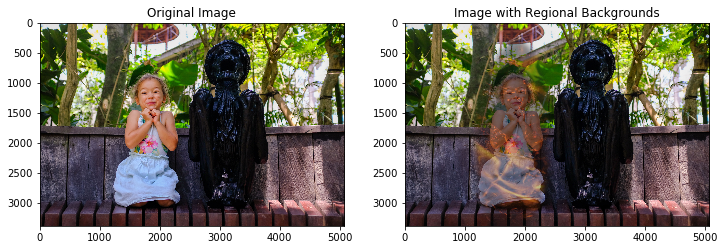

In [42]:
def addbackgroundshadow(image,mask,backgroundimagepath):
    alphaparam = 0.33
    regions = regionprops(label(mask))
    withgaussian = True
    
    bimg = Image.open(backgroundimagepath)
    bimg = bimg.resize((image.shape[1], image.shape[0]), PIL.Image.ANTIALIAS)
    bimg = img_as_float(np.array(bimg))
        
    imgcpy = img_as_float(image.copy())
    outimage = img_as_float(image.copy())
    
    alpha = np.zeros([image.shape[0],image.shape[1],3])
    for props in regions:   
        y0, x0 = props.centroid
        orientation = props.orientation
        rr, cc = ellipse(props.centroid[0], props.centroid[1], 0.7*props.major_axis_length \
                        , 0.6*props.minor_axis_length, shape = image.shape, rotation = orientation)        
        alpha[rr,cc,0] = 0.5

    if withgaussian:
        alpha[:,:,0] = gaussian_filter(alpha[:,:,0], sigma=50.0)
    alpha[:,:,1] = alpha[:,:,0]
    alpha[:,:,2] = alpha[:,:,0]
    outimage = np.multiply(alpha,bimg) + np.multiply(1-alpha,imgcpy)
        
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(12,12)
    ax1.set_title('Original Image')
    ax1.imshow(image)
    ax2.set_title('Image with Regional Backgrounds')
    ax2.imshow(outimage)
    return outimage

shadowedimg = addbackgroundshadow(testtransimg,testmask,'fire.jpeg')

Processing 1 images
image                    shape: (3381, 5072, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 5072.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


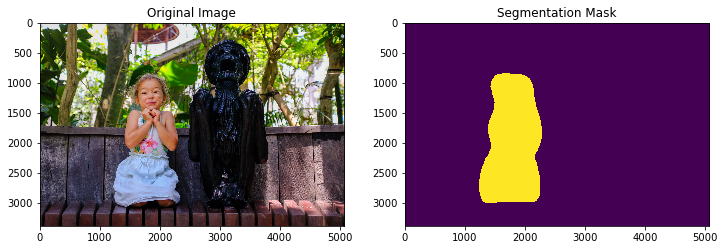

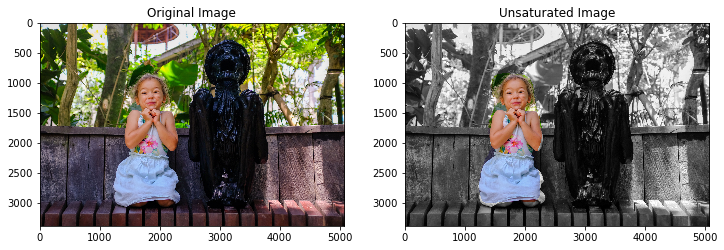

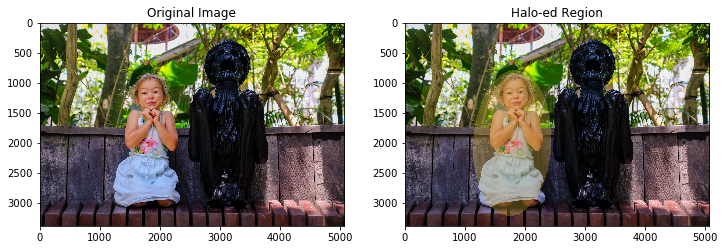

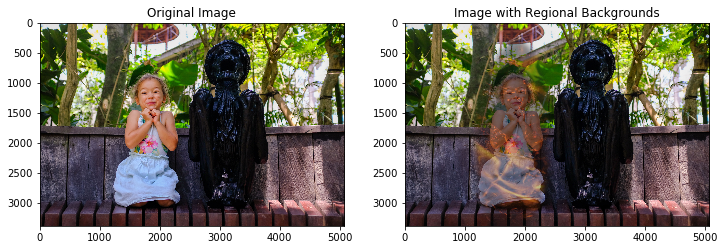

In [43]:
def personsegment(imagepath):
    segment_maskrcnn = Segmentor('maskrcnn_coco_tf')
    transimg, mask = segment_maskrcnn.segment(imagepath)
    segment_maskrcnn.showresults(transimg, mask)
    outimages = []
    outimages.append(unsaturate(transimg, mask))
    outimages.append(addhalo(transimg, mask))
    outimages.append(addbackgroundshadow(transimg, mask,'fire.jpeg'))
    return transimg,outimages

inimglist, outimglist = personsegment(testfile)


Processing 1 images
image                    shape: (1166, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (3337, 5005, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 5005.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (3478, 5217, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.1

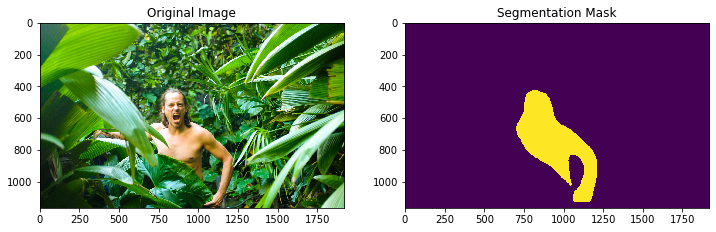

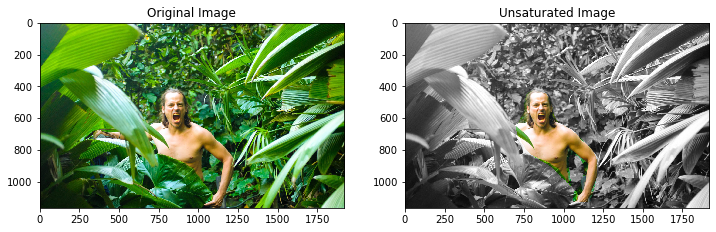

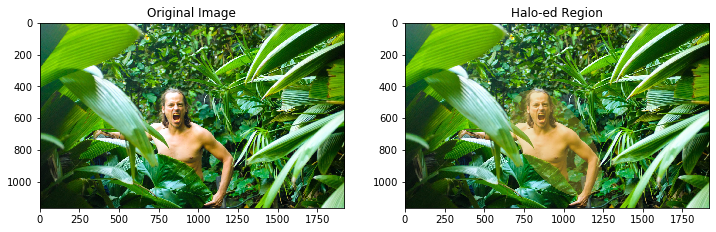

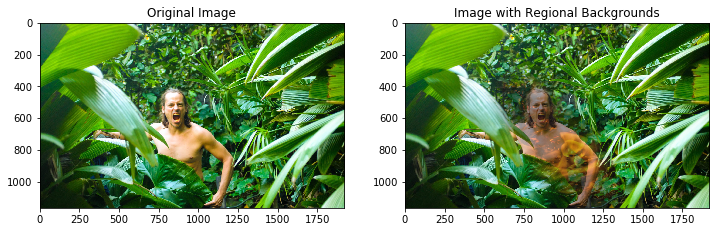

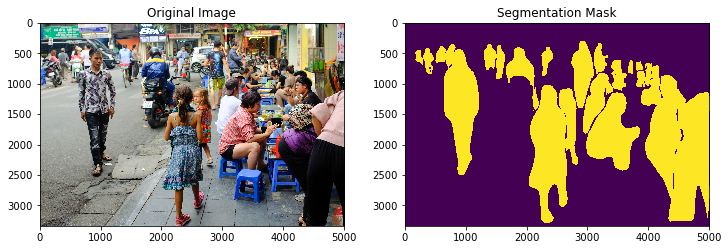

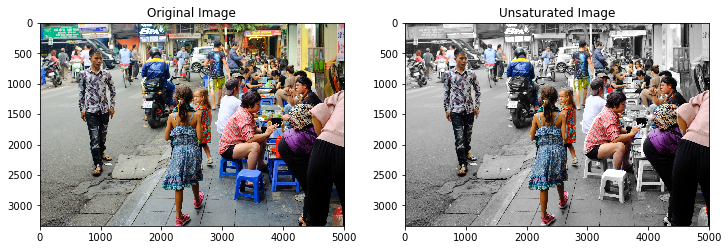

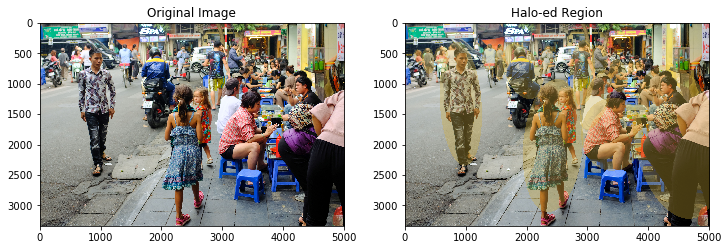

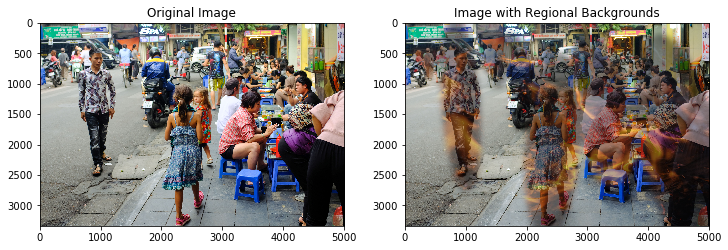

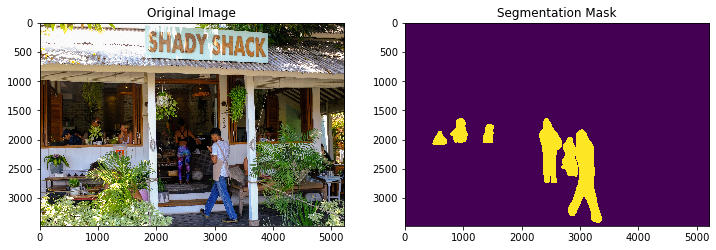

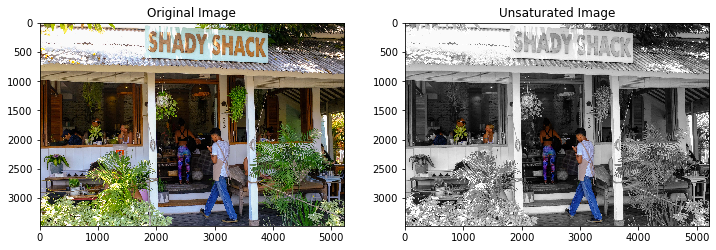

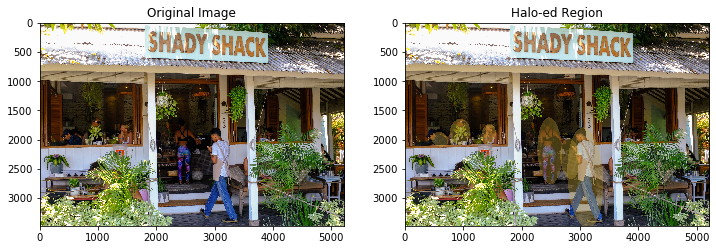

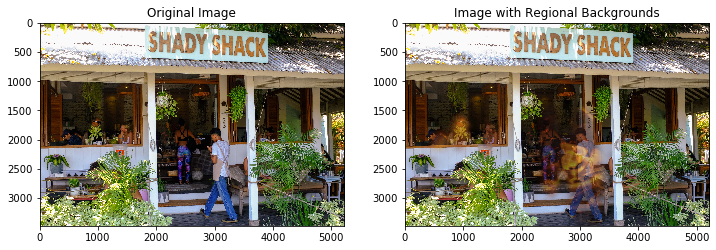

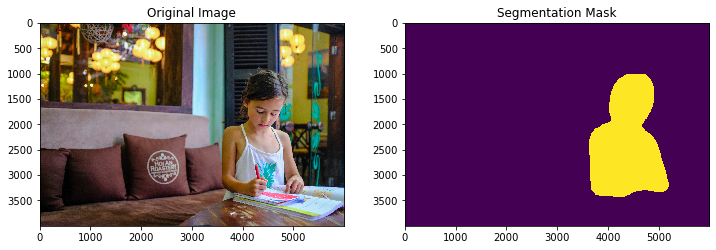

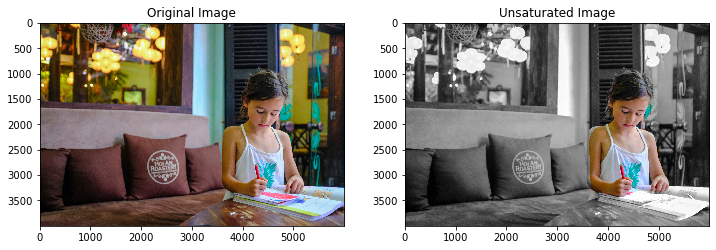

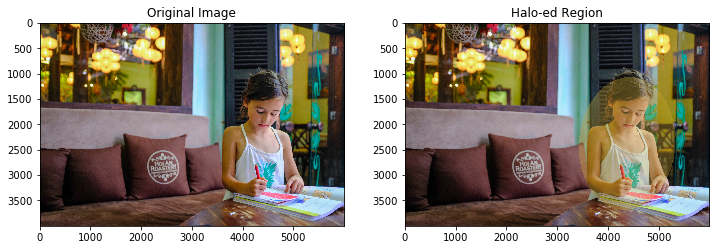

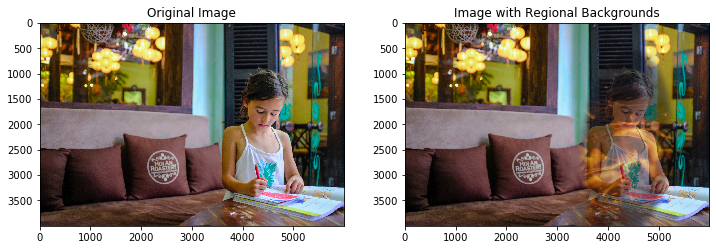

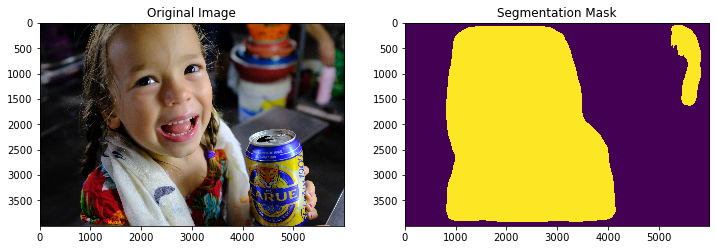

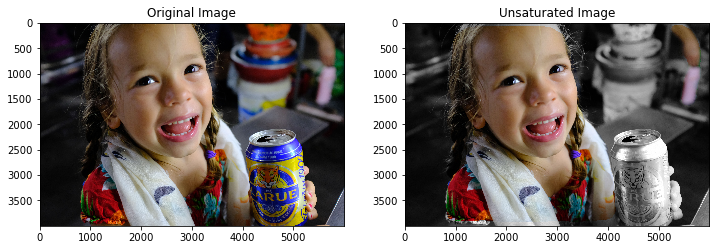

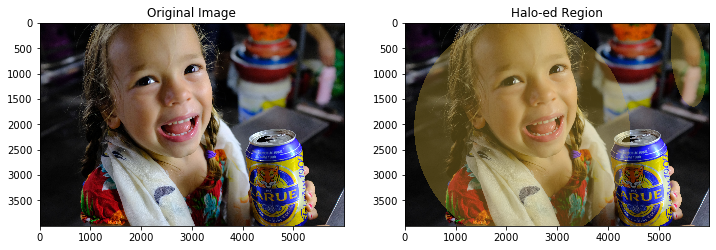

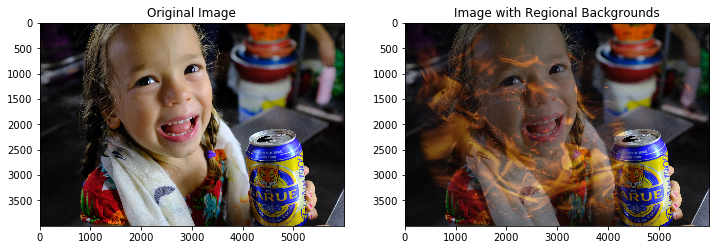

In [44]:
# load input files and set parameters
# this runs across a few random files in subdirectories specified under path
numberoffiles = 5

# Add parent directory with test photos here
path = '/Users/jimkleban/Desktop/Published Trip Photos'
outpath = '/Users/jimkleban/Desktop/Autogenerated/'
files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if '.jpg' in file:
            files.append(os.path.join(r, file))

random.shuffle(files)

for r in range(0,numberoffiles):
    #img = mpimg.imread(files[r])
    #scalefactor = 1024 / max(img.shape[0],img.shape[1])
    #img = rescale(img, scalefactor, anti_aliasing=True, multichannel=True)
    
    filebase = files[r].split('/')[-1]
    basename = filebase.split('.')[0]
    ext = filebase.split('.')[1]

    #mpimg.imsave(basename+'_1024.'+ext,testimage)
    #imageformask = open_image(basename+'_1024.'+ext)
    #imageformask = open_image(files[r])
    inimg, outputimglist = personsegment(files[r])    

    plt.imsave(outpath+basename+'_scaled.'+ext,inimg)
    for ctr in range(0,len(outputimglist)):
        plt.imsave(outpath+basename+'_scaled_personsegment_'+str(ctr+1)+'.'+ext, outputimglist[ctr])
        